Implementing Naive Bayes Using Scikit-Learn

In [127]:
import random,string,math,csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from pylab import *
%pylab inline
from sklearn.naive_bayes import GaussianNB

Populating the interactive namespace from numpy and matplotlib


C:\Users\Eduar\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['power', 'linalg', 'random', 'info', 'fft']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [128]:
#random seed
np.random.seed(42)

In [129]:
data_train =  np.loadtxt( 'training.csv', delimiter=',', skiprows=1, converters={32: lambda x:int(x=='s'.encode('utf-8')) } )

In [130]:
data_train[:,1]

array([ 138.47 ,  160.937, -999.   , ...,  105.457,   94.951, -999.   ])

In [131]:
data_train = np.where(data_train==-999.0,0., data_train) 

In [132]:
data_train[:,1]

array([138.47 , 160.937,   0.   , ..., 105.457,  94.951,   0.   ])

In [133]:
r =np.random.rand(data_train.shape[0])

In [134]:
# Put Y(truth), X(data), W(weight), and I(index) into their own arrays
print('Assigning data to numpy arrays.')

p = 0.7;
# First 90% are training
Y_train = data_train[:,32][r<p]
X_train = data_train[:,1:31][r<p]
W_train = data_train[:,31][r<p]
# Lirst 10% are validation
Y_valid = data_train[:,32][r>=p]
X_valid = data_train[:,1:31][r>=p]
W_valid = data_train[:,31][r>=p]

Assigning data to numpy arrays.


In [135]:
clf = GaussianNB()

In [136]:
clf.fit(X_train,Y_train,W_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [137]:
prob_predict_train = clf.predict_proba(X_train)[:,1]
prob_predict_valid = clf.predict_proba(X_valid)[:,1]

In [138]:
def AMSScore(s,b): 
    return  math.sqrt (2.*( (s + b + 10.)*math.log(1.+s/(b+10.))-s))

In [139]:
amstrain = [];
amsvalid  = [];

for i in range(1,100):
    pcut = np.percentile(prob_predict_train,i)
    #print(i)
    # This are the final signal and background predictions
    Yhat_train = prob_predict_train > pcut 
    Yhat_valid = prob_predict_valid > pcut

    # To calculate the AMS data, first get the true positives and true negatives
    # Scale the weights according to the r cutoff.
    TruePositive_train = W_train*(Y_train==1.0)*(1.0/0.9)
    TrueNegative_train = W_train*(Y_train==0.0)*(1.0/0.9)
    TruePositive_valid = W_valid*(Y_valid==1.0)*(1.0/0.1)
    TrueNegative_valid = W_valid*(Y_valid==0.0)*(1.0/0.1)

    # s and b for the training 
    s_train = sum ( TruePositive_train*(Yhat_train==1.0) )
    b_train = sum ( TrueNegative_train*(Yhat_train==1.0) )
    s_valid = sum ( TruePositive_valid*(Yhat_valid==1.0) )
    b_valid = sum ( TrueNegative_valid*(Yhat_valid==1.0) )
    
    amstrain.append(AMSScore(s_train,b_train))
    amsvalid.append(AMSScore(s_valid,b_valid))

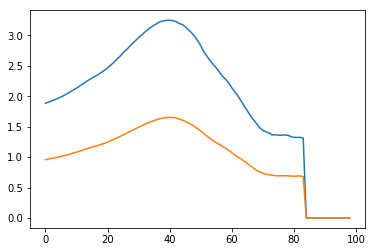

In [140]:
plt.plot(amsvalid)
plt.plot(amstrain)

In [141]:
#Olhómetro

pcut = 0.40

In [142]:
data_test = np.loadtxt( 'test.csv', delimiter=',', skiprows=1 )
X_test = data_test[:,1:31]

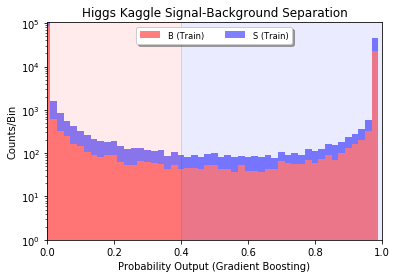

In [143]:

Classifier_training_S = clf.predict_proba(X_train[Y_train>0.5])[:,1].ravel()
Classifier_training_B = clf.predict_proba(X_train[Y_train<0.5])[:,1].ravel()


#Classifier_testing_A = clf.predict_proba(X_test)[:,1].ravel()
  
#c_max = max([Classifier_training_S.max(),Classifier_training_B.max(),Classifier_testing_A.max()])
#c_min = min([Classifier_training_S.min(),Classifier_training_B.min(),Classifier_testing_A.min()])
c_max = max([Classifier_training_S.max(),Classifier_training_B.max()])
c_min = min([Classifier_training_S.min(),Classifier_training_B.min()])
  
# Get histograms of the classifiers
Histo_training_S = np.histogram(Classifier_training_S,bins=50,range=(c_min,c_max))
Histo_training_B = np.histogram(Classifier_training_B,bins=50,range=(c_min,c_max))
#Histo_testing_A = np.histogram(Classifier_testing_A,bins=50,range=(c_min,c_max))
  
# Lets get the min/max of the Histograms
AllHistos= [Histo_training_S,Histo_training_B]
h_max = max([histo[0].max() for histo in AllHistos])*1.2
# h_min = max([histo[0].min() for histo in AllHistos])
h_min = 1.0
  
# Get the histogram properties (binning, widths, centers)
bin_edges = Histo_training_S[1]
bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
bin_widths = (bin_edges[1:] - bin_edges[:-1])
  
# To make error bar plots for the data, take the Poisson uncertainty sqrt(N)
#ErrorBar_testing_A = np.sqrt(Histo_testing_A[0])
# ErrorBar_testing_B = np.sqrt(Histo_testing_B[0])
  
# Draw objects
ax1 = plt.subplot(111)
  
# Draw solid histograms for the training data
ax1.bar(bin_centers-bin_widths/2.,Histo_training_B[0],facecolor='red',linewidth=0,width=bin_widths,label='B (Train)',alpha=0.5)
ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],bottom=Histo_training_B[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
 
#ff = (1.0*(sum(Histo_training_S[0])+sum(Histo_training_B[0])))/(1.0*sum(Histo_testing_A[0]))
 
# # Draw error-bar histograms for the testing data
#ax1.errorbar(bin_centers, ff*Histo_testing_A[0], yerr=ff*ErrorBar_testing_A, xerr=None, ecolor='black',c='black',fmt='.',label='Test (reweighted)')
# ax1.errorbar(bin_centers, Histo_testing_B[0], yerr=ErrorBar_testing_B, xerr=None, ecolor='red',c='red',fmt='o',label='B (Test)')
  
# Make a colorful backdrop to show the clasification regions in red and blue
ax1.axvspan(pcut, c_max, color='blue',alpha=0.08)
ax1.axvspan(c_min,pcut, color='red',alpha=0.08)
  
# Adjust the axis boundaries (just cosmetic)
ax1.axis([c_min, c_max, h_min, h_max])
  
ax1.set_yscale('log')
    
# Make labels and title
plt.title("Higgs Kaggle Signal-Background Separation")
plt.xlabel("Probability Output (Gradient Boosting)")
plt.ylabel("Counts/Bin")
 
# Make legend with smalll font
legend = ax1.legend(loc='upper center', shadow=True,ncol=2)
for alabel in legend.get_texts():
            alabel.set_fontsize('small')
  
# Save the result to png
plt.savefig("Sklearn_gbc.png")

## Calculating Test

In [ ]:
test = list(csv.reader(open("test.csv","r"), delimiter=','))

test = np.where(test==-999.0,0., test) 

In [ ]:
xsTest = np.array(test)[1:,1:].astype(float)
testIds = np.array([int(row[0]) for row in test[1:]])

In [150]:
#xsTest

In [146]:
def score(x):
    logP = 0
    for fI in range(numFeatures):
        bI = 0
        # linear search for the bin index of the fIth feature
        # of the signal
        while bI < len(binMaxs[fI]) - 1 and x[fI] > binMaxs[fI, bI]:
            bI += 1
        logP += logPs[fI, bI] - math.log(0.5)
    return logP

In [147]:
testScores = np.array(score(x) for x in xsTest)

In [148]:
testInversePermutation = np.array(testScores).argsort()
testPermutation = list(testInversePermutation)
for tI,tII in zip(range(len(testInversePermutation)),
                  testInversePermutation):
    testPermutation[tII] = tI


In [ ]:
clf.predict_proba(xsTest)